<a href="https://colab.research.google.com/github/HumayraFerdous/Hybrid-Models/blob/master/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/Mall_Customers.csv')
data.head()
data.isnull().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [50]:
original_gender_mode = data['Gender'].mode()[0]
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
if original_gender_mode == 'Male':
    data.loc[:, 'Gender'] = data['Gender'].fillna(0)
elif original_gender_mode == 'Female':
    data.loc[:, 'Gender'] = data['Gender'].fillna(1)
features = ['Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
X_raw = data[features].values

In [54]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_raw)

In [55]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

In [56]:
kmeans = KMeans(n_clusters=3, random_state=42)
y = kmeans.fit_predict(X_scaled)
y_cat = to_categorical(y)

In [57]:
X_seq = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_cat, test_size=0.2, random_state=42)

In [59]:
model = Sequential([
    SimpleRNN(16, activation='relu', input_shape=(4, 1)),
    Dense(16, activation='relu'),
    Dense(3, activation='softmax')  # 3 clusters
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=8, verbose=0)

In [61]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 1.0000 - loss: 0.0291 
Test Accuracy: 1.00


In [62]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_labels))

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 346ms/step

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        11

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



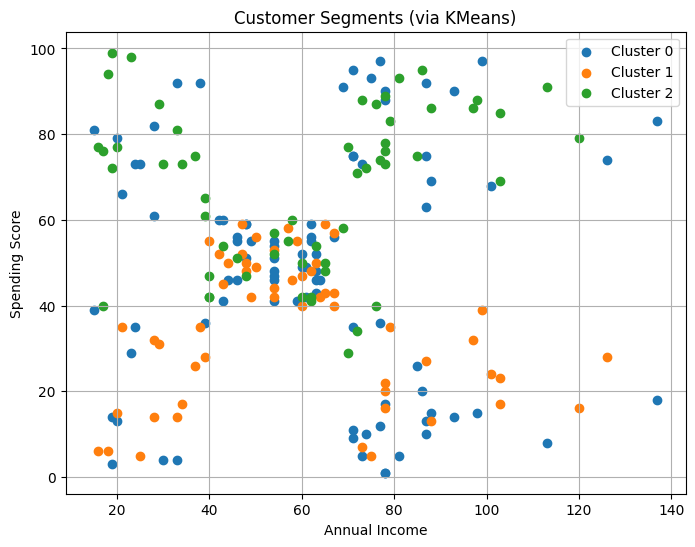

In [65]:
import matplotlib.pyplot as plt

data['Cluster'] = y
plt.figure(figsize=(8, 6))
for cluster in data['Cluster'].unique():
    subset = data[data['Cluster'] == cluster]
    plt.scatter(subset['Annual Income (k$)'], subset['Spending Score (1-100)'], label=f"Cluster {cluster}")

plt.xlabel("Annual Income")
plt.ylabel("Spending Score")
plt.title("Customer Segments (via KMeans)")
plt.legend()
plt.grid(True)
plt.show()